**Pridobitev podatkov**

Za pridobitev podatkov smo uporabili Pythonovo knjižnico Pandas, saj je z le to enostavno delati. Najprej smo prebrali podatke iz vsake .csv datoteke posebej (za Windows in Mac operacijske sisteme smo uporabili drugačen delilec poti do datotek), ter jih shranili v slovar, kot ključ: ime datoteke, vrednost: pandas dataframe te datoteke.

In [1]:
import pandas as pd
import glob
import warnings
import platform
from copy import copy
warnings.filterwarnings('ignore')

if (platform.system() == 'Windows'):
    l = glob.glob('data/*.csv')
    for i in range(len(l)):
        l[i] = l[i].split('\\')[-1].upper()

    # slovar poti do .csv datotek
    csv_data = {data.split('\\')[1].split('.')[0].upper():data for data in glob.glob('data/*.csv')}
    
    # MAC IN LINUX IMATA DRUGACNE OZNAKE
else:
    l = glob.glob('data/*.csv')
    for i in range(len(l)):
        l[i] = l[i].split('/')[-1].upper()

    # slovar poti do .csv datotek
    csv_data = {data.split('/')[1].split('.')[0].upper():data for data in glob.glob('data/*.csv')}

In [2]:
dataframes = {}
for key, value in csv_data.items():
    df = pd.read_csv(csv_data[key], sep=';', encoding='cp1250', skipinitialspace = True)
    dataframes[key.upper()] = df

for df1 in dataframes.values():
    df1.columns = ['MesecStoritve' if x == 'DatumStoritve' else x for x in df]

Iz ustvarjenega seznama smo nato združili vse podatke v dataframe vseh podatkov, da ne bi prišlo do zmede med letnico napisano na dokumentu in dejansko letnico kadar je bilo kaznivo dejanje storjeno. V ta namen smo naredili dataframe full_KD, v katerega smo dodali stolpec MesecStoritve ter LetoStoritve.

In [3]:
dataframes_copy = copy(dataframes)
frames = [copy(dataframes_copy['KD2009'])]
for i in range(10, 21):
    frames.append(copy(dataframes_copy['KD20'+str(i)]))

all_data = pd.concat(frames)
all_data

# tu se naredi preslikava glede iz neberljive oblike datuma v berljivo obliko
mesci = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']
mesci2 = []
leta = []

# this dataframe is the one used for the analysis
full_KD = all_data

for i in full_KD['MesecStoritve']:
    mesec = str(i)[:-4]
    leto = str(i)[-4:]

    leta.append(leto)
    mesci2.append(mesci[int(mesec) - 1])


full_KD.rename(columns={'MesecStoritve': 'CasovnaOznaka'}, inplace=True)
full_KD['MesecStoritve'] = mesci2
full_KD['LetoStoritve'] = leta
full_KD['LetoStoritve'] = full_KD['LetoStoritve'].astype(int)

Da bi bili grafi bolj usklajeni med seboj smo uporabili naslednjo barvno paleto:

In [4]:
color_pallete = ['#FF0170', '#F72585', '#B5179E', '#7209B7', '#560BAD', '#480CA8', '#3A0CA3', '#3F37C9', '#4361EE', '#4895EF', '#4CC9F0', '#82D8F2']

**Število kaznivih dejanj v Sloveniji po občinah**

Zanimalo nas je kako se med seboj po kaznivih dejanjih med seboj razlikujejo posamezne občine Slovenije.    
Za karseda berljiv prikaz smo uporabili knjižnico Geopandas, ki omogoča prikaz zemljevida in ga obarva glede na stolpec v katerem so števila, ki jih želimo prikazati. Uporabili smo .shp datoteke Slovenije in sicer v mapi "slovenija_map/obcine/obc.shp" za občine Slovenije in "slovenija_map/regije/reg.shp" za Slovenske regije.

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt

obcine = dict(full_KD.UpravnaEnotaStoritve.value_counts())
obcine_popravljene = {}
odstrani = ['NEZNANA OBČ', 'NEZNANA UE', 'NI PODATKA']
for o in odstrani:
    if o in obcine.keys():
        obcine.pop(o)

for key, value in obcine.items():
    crke = ['Č', 'Š', 'Ž']
    k = key
    for i in 'ČŠŽ':
        k = k.replace(i, '?')
    obcine_popravljene[k] = value
obcine_popravljene

obcine_popravljene['LJUBLJANA'] = obcine_popravljene['LJUBLJANA']

slovenia = gpd.read_file('slovenija_map/obcine/obc.shp', encoding='cp1250')
slovenia['name_2'] = slovenia['name_2'].str.upper()

list_of_all = list(slovenia.name_2)
list_stevio = []

for i in list_of_all:
    if i in obcine_popravljene.keys():
        list_stevio.append(obcine_popravljene[i])
    else:
        list_stevio.append(0)

slovenia['stevilo'] = list_stevio
fig, ax = plt.subplots(1, figsize=(20, 20))
plt.axis('off')
plt.title('Pogostost kaznivih dejanj v Sloveniji po občinah', fontsize=20)
slovenia.plot(column='stevilo', cmap='RdYlGn', ax=ax, edgecolor='.2')
bar_info = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=0, vmax=max(obcine.values())))
bar_info._A = []
cbar = fig.colorbar(bar_info, shrink=0.55)
cbar.set_label('Število kaznivih dejanj', fontsize=15, rotation=270, labelpad=40)

ModuleNotFoundError: No module named 'geopandas'

**Ugotovitve:**    
Iz zemljevida je kot po pričakovanjih razvidno da je največ kaznivih dejanj pripisanih Ljubljani(500.000 primerov), naslednja občina pa je občina Maribor(200.000 primerov). Ostale občine se gibljejo okoli 100.000 primerov kaznivih dejanj in manj. 

**Število storjenih kaznivih dejanj skozi leta**    
Naslednje nas je zanimalo kako se spreminja število primerov kaznivih dejanj skozi leta. Za prikaz smo uporabili barplot. Za stolpes smo uporabili stolpec 'LetoStoritve'.

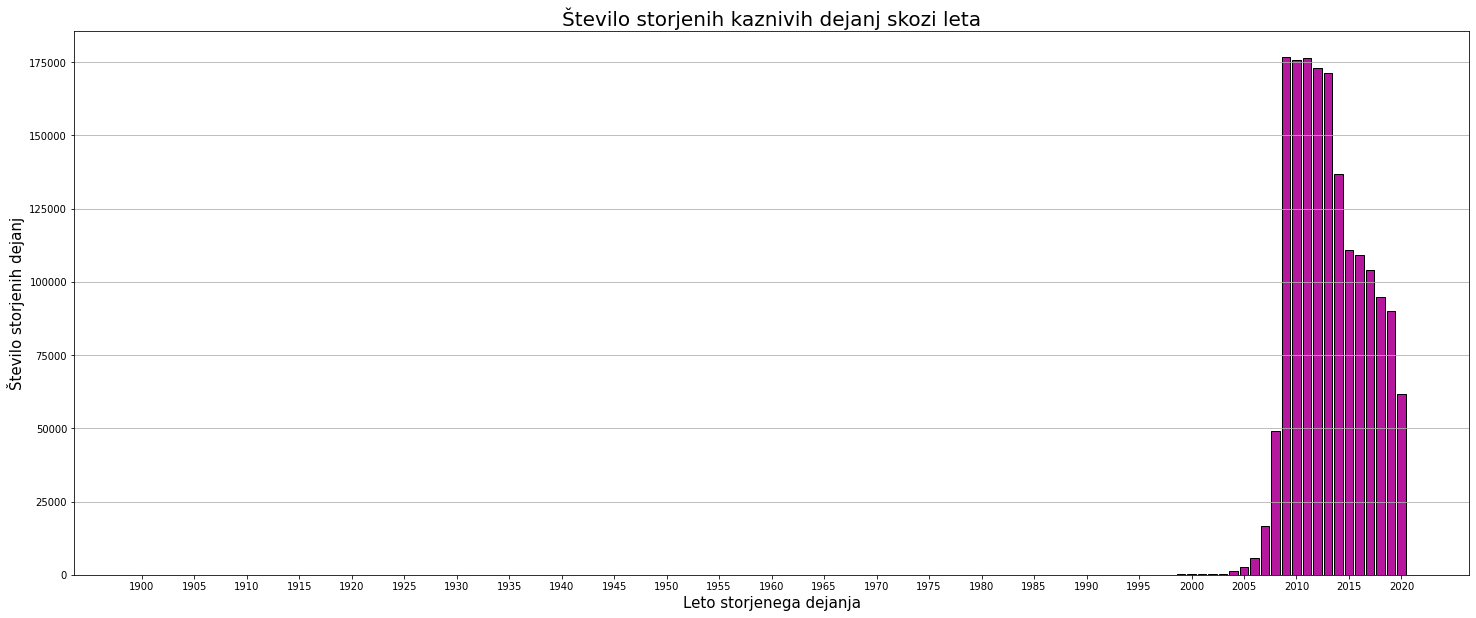

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

all_years = copy(all_data)
leta = all_years['LetoStoritve'].value_counts().sort_index()
x = list(leta.index)
y = list(leta)

plt.figure(figsize=(25,10))
plt.bar(x, y, color=color_pallete[2], edgecolor='black')
plt.grid(axis='y')
plt.title('Število storjenih kaznivih dejanj skozi leta', fontsize=20)
plt.xlabel('Leto storjenega dejanja', fontsize=15)
plt.ylabel('Število storjenih dejanj', fontsize=15)
plt.xticks(np.arange(x[0], x[-1]+5, step=5))
plt.show()

**Ugotovitve:**    
Iz grafa vidimo, da je do leta 2005 zabeleženih zelo malo primerov, saj imamo podatke v dokumentih zaključenih primerov. Kar pomeni da so potrebovali za primere starejše od leta 2005 zelo veliko časa. Iz grafa lahko razberemo da je največ primerov okoli leta 2010 in proti letu 2020 pada. Padec nam lahko pove da nekateri primeri iz teh let še niso bili zaključeni in da povprečnopotrebujejo okoli 5 let za zakjuček primera kaznivega dejanja.

**Razmerje med primeri, zaključenimi isto lete, ter primeri, ki niso bili zaključeni isto leto**    

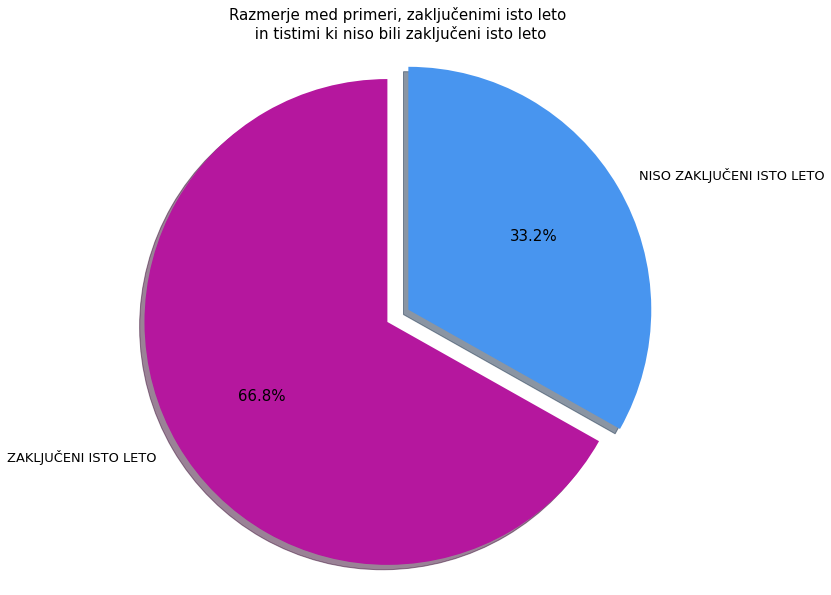

In [ ]:
df_istoleto = copy(all_data)
df_not_istoleto = copy(all_data)
df_istoleto = df_istoleto[df_istoleto['LetoZakljucnegaDokumenta'] == df_istoleto['LetoStoritve']]
df_not_istoleto = df_not_istoleto[df_not_istoleto['LetoZakljucnegaDokumenta'] != df_not_istoleto['LetoStoritve']]
zalkjuceni_istoleto = len(df_istoleto)
ne_zalkjuceni_istoleto = len(df_not_istoleto)

x = ['ZAKLJUČENI ISTO LETO', 'NISO ZAKLJUČENI ISTO LETO']
y = [int(zalkjuceni_istoleto), int(ne_zalkjuceni_istoleto)]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
fig1.set_size_inches(10,10)
patches, texts, autotexts = ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%', shadow=True, startangle=90, colors=[color_pallete[2], color_pallete[9]])
ax1.axis('equal')
ax1.set_title('Razmerje med primeri, zaključenimi isto leto\n in tistimi ki niso bili zaključeni isto leto', fontsize=15)
for t in autotexts:
    t.set_fontsize(15)
for t in texts:
    t.set_fontsize(13)
plt.show()

**Ugotovitve:**    
Iz prikazanega grafa lahko vidimo, da sta  dve tretjini primerov zaključeni isto leto tretjina pa ne, kar nam lahko razloži padec v grafu iz prejšnjih ugotovitev.

**Število kaznivih dejanj po dnevih v tednu**


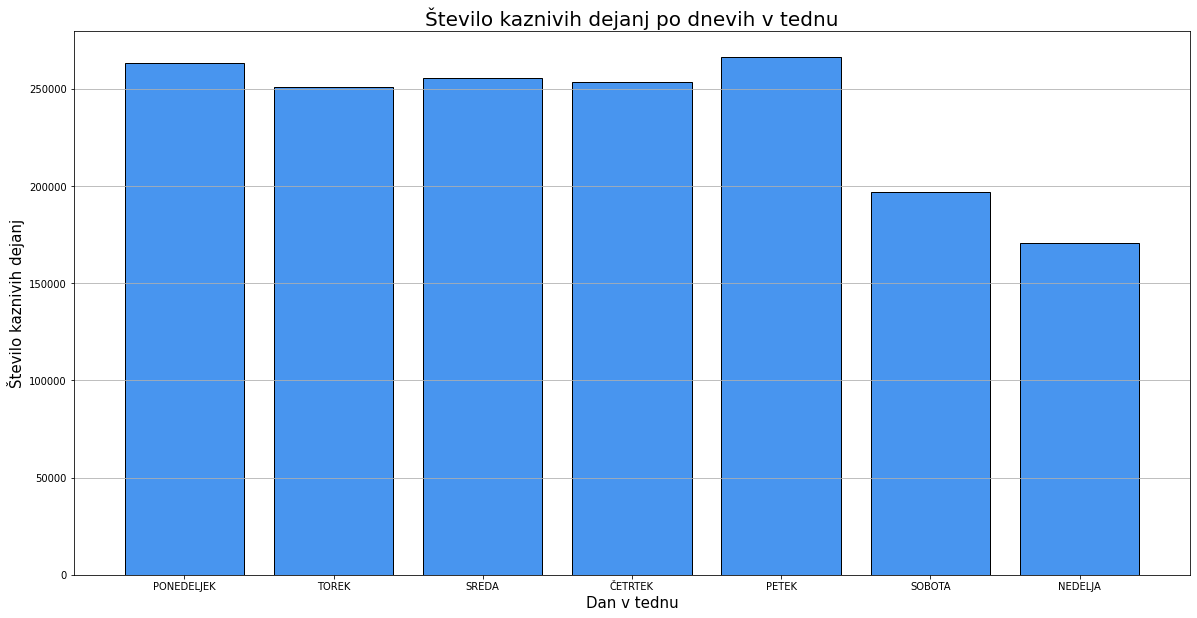

In [ ]:
dnevi = all_years.DanVTednu.value_counts().sort_index()
x = ['PONEDELJEK', 'TOREK', 'SREDA', 'ČETRTEK', 'PETEK', 'SOBOTA', 'NEDELJA']
y = [dnevi.PONEDELJEK, dnevi.TOREK, dnevi.SREDA, dnevi.ČETRTEK, dnevi.PETEK, dnevi.SOBOTA, dnevi.NEDELJA]

plt.figure(figsize=(20,10))
plt.bar(x, y, color=color_pallete[9], edgecolor='black')
plt.title('Število kaznivih dejanj po dnevih v tednu', fontsize=20)
plt.xlabel('Dan v tednu', fontsize=15)
plt.ylabel('Število kaznivih dejanj', fontsize=15)
plt.grid(axis='y')
plt.show()

**Ugotovitve:**    
Iz grafa lahko vidimo, da je največ primerov kaznivih dejanj med tednom. Med vikendom pa je le teh največ v soboto, nekoliko manj pa v nedeljo.

**Število zaključenih primerov kaznivih dejanj po letih za leta 2009-2020**

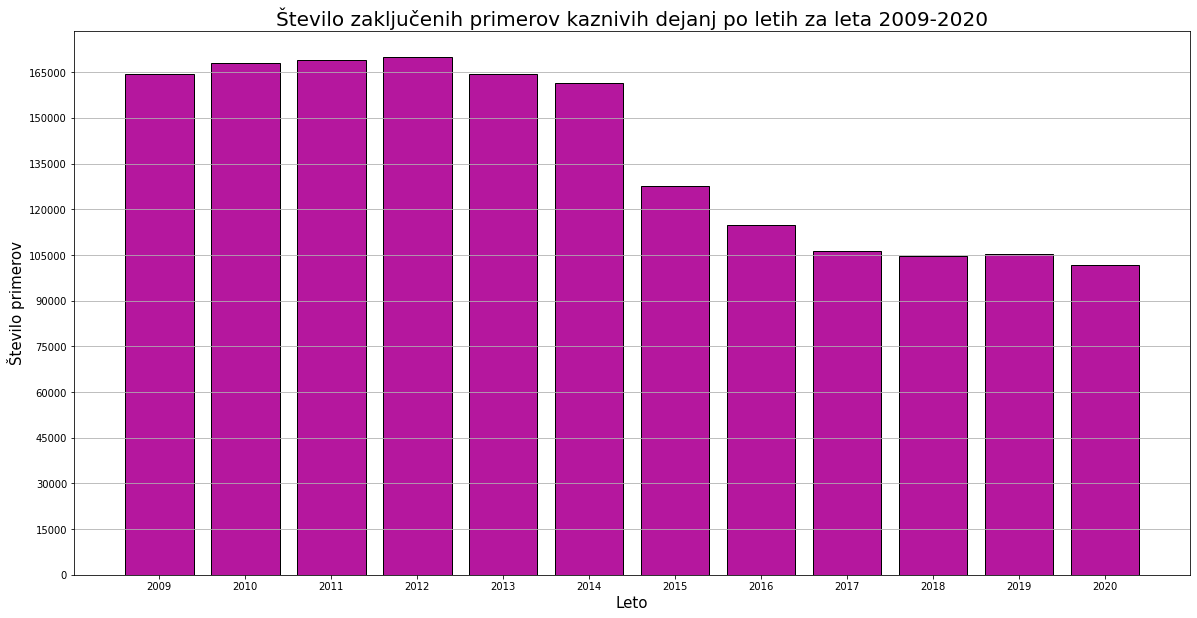

In [ ]:
time_dataframes = {k:v for k,v in dataframes.items()}

l_df = copy(list(time_dataframes.values()))

po_letih = [len(df) for df in l_df]

plt.figure(figsize=(20,10))

# subplot 1. prikaz kriminalističih primerov po letih za leta 2009-2020
plt.bar(['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020'], po_letih, color=color_pallete[2], edgecolor='black')
plt.yticks(np.arange(0, 180000, step=15000))
plt.grid(axis='y')
plt.title('Število zaključenih primerov kaznivih dejanj po letih za leta 2009-2020', fontsize=20)
plt.ylabel('Število primerov', fontsize=15)
plt.xlabel('Leto', fontsize=15)
plt.show()

**Ugotavljanje v katerih urah se zgodi največ kriminala**  
Pri tej analizi uporabimo podatke za vsa leta po stolpcu **UraStoritve** ter jih povprečimo da dobimo bolj splošne rezultate

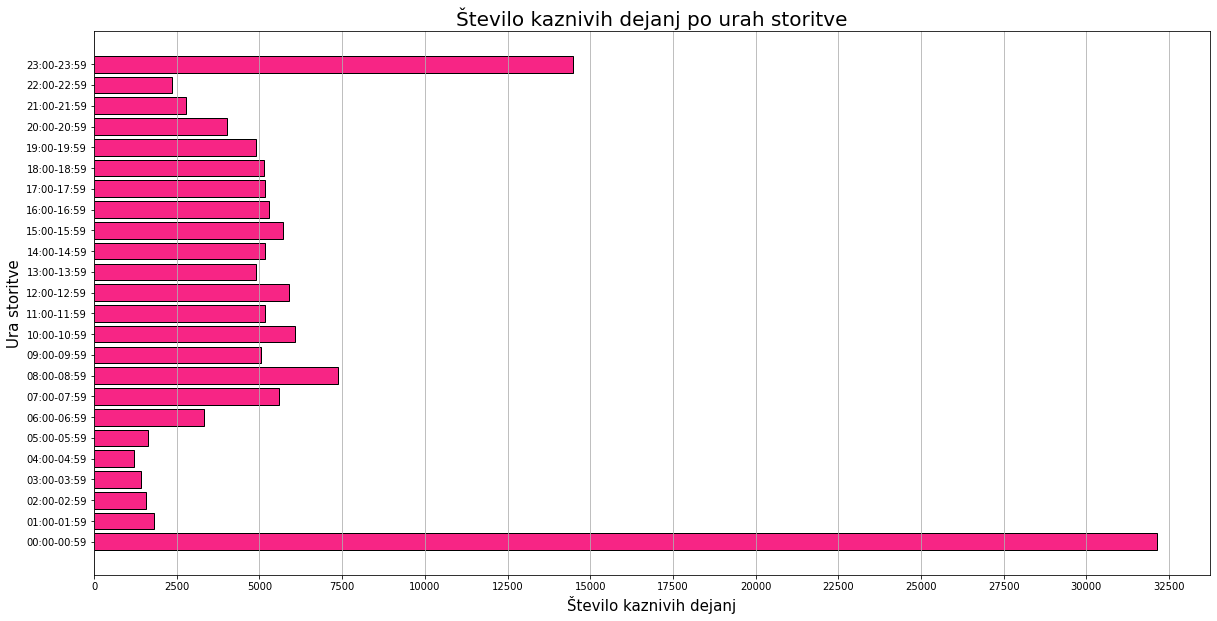

In [ ]:
dataframes_fixed_dates = {}

for key, value in time_dataframes.items():
    df1 = copy(time_dataframes[key])
    df1['MesecStoritve'] = df1['MesecStoritve'].apply(lambda x: str(x)[:-4]+'.'+str(x)[-4:])
    df1['MesecStoritve'] =  pd.to_datetime(df1['MesecStoritve'], format='%m.%Y')
    dataframes_fixed_dates[key] = df1

ure_vse = []
povp_ure = []
ure = [
    '00:00-00:59',
    '01:00-01:59',
    '02:00-02:59',
    '03:00-03:59',
    '04:00-04:59',
    '05:00-05:59',
    '06:00-06:59',
    '07:00-07:59',
    '08:00-08:59',
    '09:00-09:59',
    '10:00-10:59',
    '11:00-11:59',
    '12:00-12:59',
    '13:00-13:59',
    '14:00-14:59',
    '15:00-15:59',
    '16:00-16:59',
    '17:00-17:59',
    '18:00-18:59',
    '19:00-19:59',
    '20:00-20:59',
    '21:00-21:59',
    '22:00-22:59',
    '23:00-23:59',
]

i = 0
for key, value in dataframes_fixed_dates.items():
    ure_vse.append(list(value['UraStoritve'].value_counts().sort_index()))
    i += 1

for i in range(len(ure_vse[1])):
    x = 0
    for ura in ure_vse:
        x += ura[i]
    povp_ure.append(x/len(ure_vse))

plt.figure(figsize=(20,10))
plt.barh(ure, povp_ure, color='#F72585', edgecolor='black')
plt.grid(axis='x')
plt.xticks(np.arange(0, 35000, step=2500))
plt.title('Število kaznivih dejanj po urah storitve', fontsize=20)
plt.ylabel('Ura storitve', fontsize=15)
plt.xlabel('Število kaznivih dejanj', fontsize=15)
plt.show()

**UGOTOVITVE:** Iz ugotovitev se največ kaznivih dejanj zgodi med **23:00 in 01:00**. V teh urah je največ ljudi prostih in je zato logično, da je v teh urah največ kaznivih dejanj. Dejavnik je tudi alkohol saj se ob takih urah odvija največ zabav in največ ljudi ob takih urah zahaja v lokale. Število kaznivih dejanj pade v urah spanca **01:00-06:00** ter **21:00-23:00**. Podnevi kazniva dejanja narastejo, ampak še vedno ne tako kot med 23:00 in 01:00.

**Povzročena škoda glede na leto, mesec, dan in časovno obdobje**    
V naslednjem poglavju smo raziskovali koliko škode je bilo povzročene glede na naslednje dejavnike:
1. Leto,
2. Mesec,
3. Dan,
4. Časovno obdobje

Najprej smo se odločili, da stolpec 'Skoda' pretvorimo tako da sestejemo spodnjo in zgornjo mejo in delimo z 2 in tako dobimo povprečno škodo tistega primera(primere brez škode in brez zapisa smo nastavili na 0) ter jo zapišemo v nov stolpec 'PovprecnaSkoda', ki bo uporaben pri analizi glede na druge stolpce.

In [ ]:
full_KD['PovprecnaSkoda'] = 'nan'

full_KD['Skoda'] = full_KD['Skoda'].replace(np.nan, 'BREZ')

#Sprememba podatka iz stolpca 'Skoda' v stolpec 'PovprecnaSkoda'
full_KD.loc[full_KD['Skoda'] == 'DO 100 EUR', 'PovprecnaSkoda'] = float(50)
full_KD.loc[full_KD['Skoda'] == '100 - 1.000 EUR', 'PovprecnaSkoda'] = float((100+1000)/2)
full_KD.loc[full_KD['Skoda'] == '1.000 - 10.000 EUR', 'PovprecnaSkoda'] = float((1000+10000)/2)
full_KD.loc[full_KD['Skoda'] == '10.000 - 100.000 EUR', 'PovprecnaSkoda'] = float((10000+100000)/2)
full_KD.loc[full_KD['Skoda'] == '100.000 - 500.000 EUR', 'PovprecnaSkoda'] = float((100000+5000000)/2)
full_KD.loc[full_KD['Skoda'] == 'NAD 500.000 EUR', 'PovprecnaSkoda'] = float(500000)
full_KD.loc[full_KD['Skoda'] == 'BREZ', 'PovprecnaSkoda'] = float(0)
full_KD.loc[full_KD['Skoda'] == np.nan, 'PovprecnaSkoda'] = float(0)

povprecna_skoda_ura = full_KD.groupby('UraStoritve')['PovprecnaSkoda'].mean().round(1)
povprecna_skoda_mesec = full_KD.groupby('MesecStoritve')['PovprecnaSkoda'].mean().round(1)
povprecna_skoda_dan = full_KD.groupby('DanVTednu')['PovprecnaSkoda'].mean().round(1)
povprecna_skoda_leto = full_KD.groupby('LetoStoritve')['PovprecnaSkoda'].mean().round(1)

**Povprečna škoda glede na leto**    


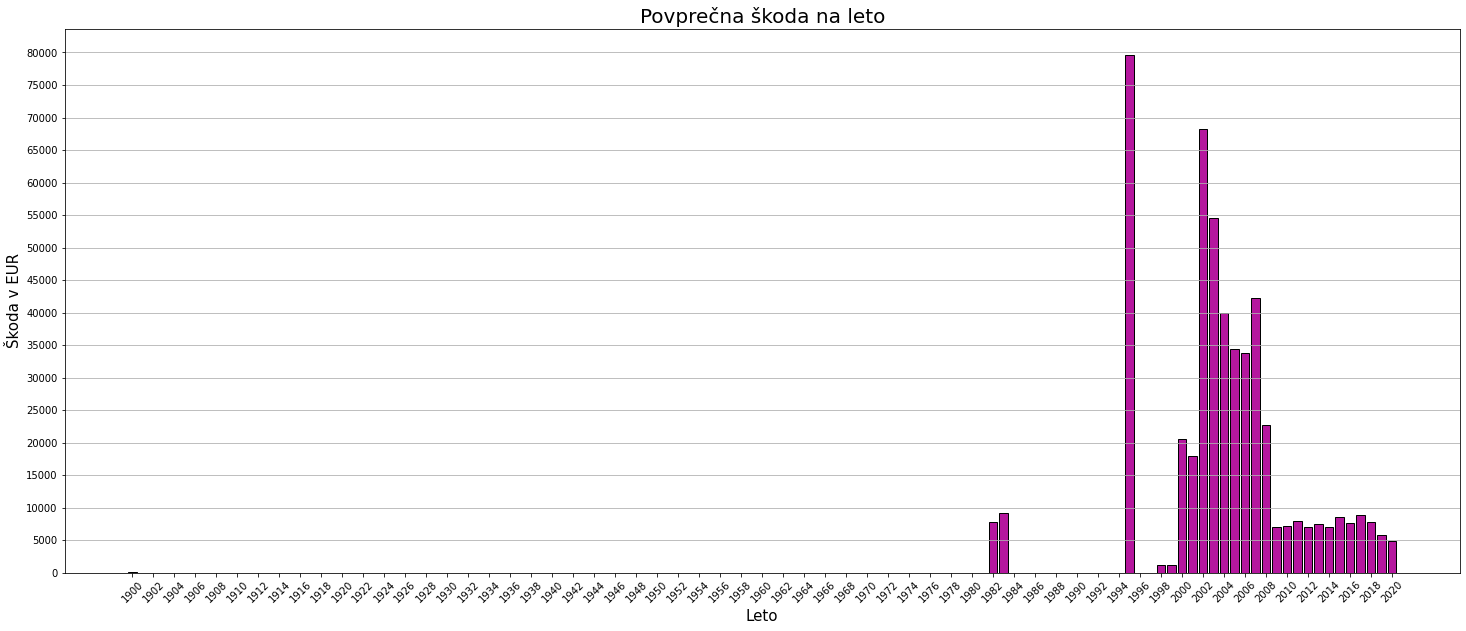

In [ ]:
povprecna_skoda_leto = povprecna_skoda_leto.sort_index()
x = list(povprecna_skoda_leto.index)
y = list(povprecna_skoda_leto.values)

plt.figure(figsize=(25,10))
plt.bar(x,y, color=color_pallete[2], edgecolor='black')
plt.xticks(np.arange(x[0], x[-1]+2, step=2), rotation=45)
plt.yticks(np.arange(0, max(y)+5000, step=5000))
plt.grid(axis='y')
plt.title('Povprečna škoda na leto', fontsize=20)
plt.xlabel('Leto', fontsize=15)
plt.ylabel('Škoda v EUR', fontsize=15)
plt.show()

**Povprečna škoda glede na mesec**

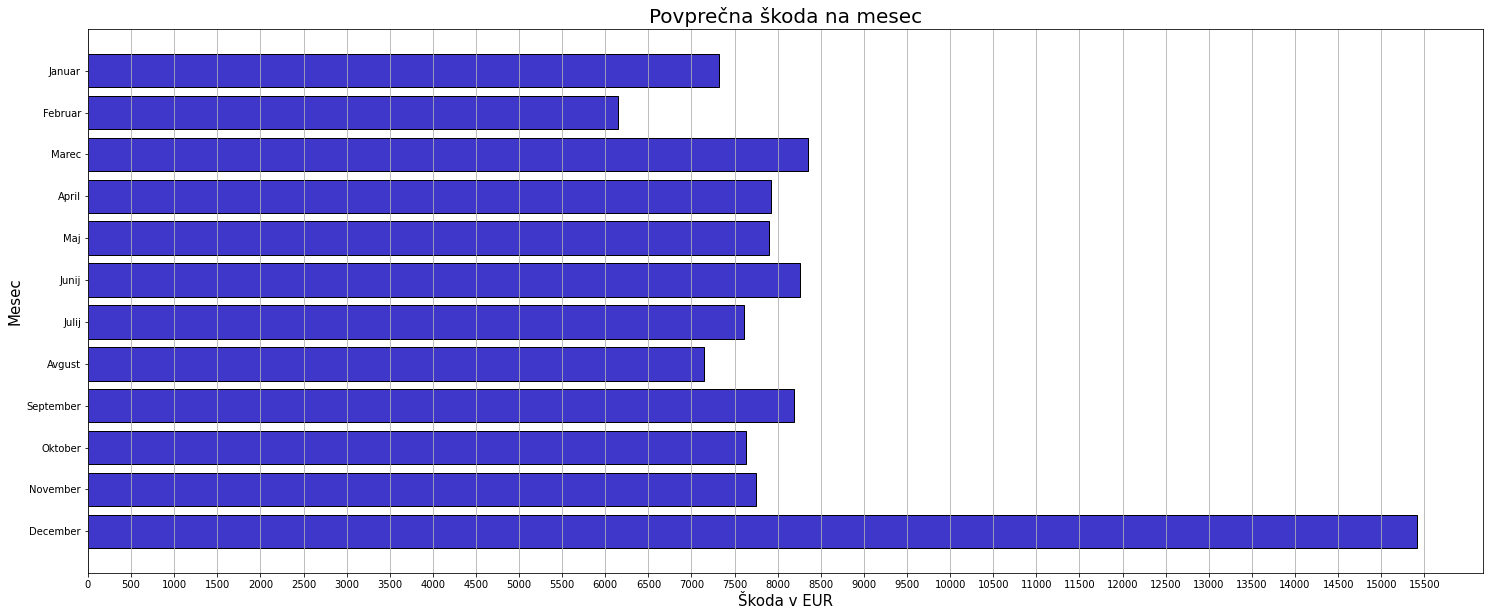

In [ ]:
x = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']
y = [
    povprecna_skoda_mesec.Januar,
    povprecna_skoda_mesec.Februar,
    povprecna_skoda_mesec.Marec,
    povprecna_skoda_mesec.April,
    povprecna_skoda_mesec.Maj,
    povprecna_skoda_mesec.Junij,
    povprecna_skoda_mesec.Julij,
    povprecna_skoda_mesec.Avgust,
    povprecna_skoda_mesec.September,
    povprecna_skoda_mesec.Oktober,
    povprecna_skoda_mesec.November,
    povprecna_skoda_mesec.December
]

x.reverse()
y.reverse()

plt.figure(figsize=(25,10))
plt.barh(x, y, color=color_pallete[7], edgecolor='black')
plt.xticks(np.arange(0, y[0]+500, step=500))
plt.grid(axis='x')
plt.title('Povprečna škoda na mesec', fontsize=20)
plt.xlabel('Škoda v EUR', fontsize=15)
plt.ylabel('Mesec', fontsize=15)
plt.show()


**Ugotovitve:**    
Iz grafa je zelo dobro razvidno, da se največ škode povzroči v mesecu Decembru. Najverjetnje je to zaradi prazničnega časa(pirotehnika, zabave, dela prosti dnevi) ter zaradi sneženega vremena(več prometnih nesreč).

**Povprečna škoda glede na dan**

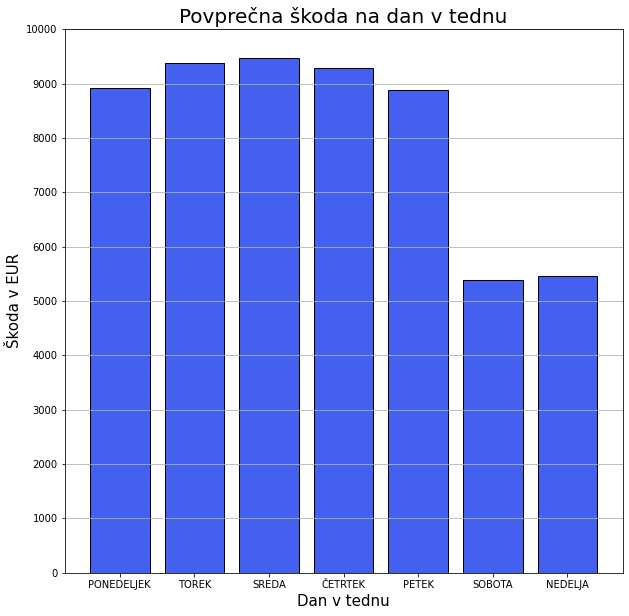

In [ ]:
x = ['PONEDELJEK', 'TOREK', 'SREDA', 'ČETRTEK', 'PETEK', 'SOBOTA', 'NEDELJA']
y = [povprecna_skoda_dan.PONEDELJEK,
     povprecna_skoda_dan.TOREK,
     povprecna_skoda_dan.SREDA, 
     povprecna_skoda_dan.ČETRTEK, 
     povprecna_skoda_dan.PETEK, 
     povprecna_skoda_dan.SOBOTA, 
     povprecna_skoda_dan.NEDELJA
]

plt.figure(figsize=(10,10))
plt.bar(x, y, color=color_pallete[8], edgecolor='black')
plt.yticks(np.arange(0, max(y)+1000, step=1000))
plt.grid(axis='y')
plt.title('Povprečna škoda na dan v tednu', fontsize=20)
plt.xlabel('Dan v tednu', fontsize=15)
plt.ylabel('Škoda v EUR', fontsize=15)
plt.show()

**Povprečna škoda glede na časovno območje**

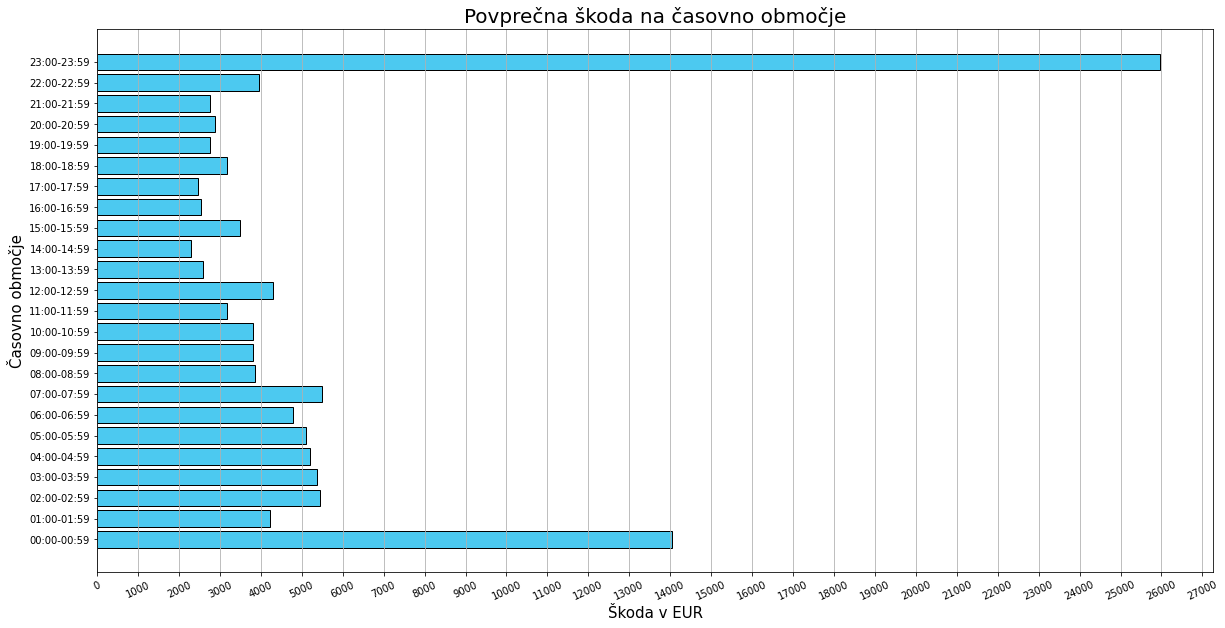

In [ ]:
x = list(povprecna_skoda_ura.index)
y = list(povprecna_skoda_ura.values)

plt.figure(figsize=(20,10))
plt.barh(x, y, color=color_pallete[10], edgecolor='black')
plt.xticks(np.arange(0, max(y)+2000, step=1000), rotation=25)
plt.grid(axis='x')
plt.title('Povprečna škoda na časovno območje', fontsize=20)
plt.xlabel('Škoda v EUR', fontsize=15)
plt.ylabel('Časovno območje', fontsize=15)
plt.show()